# Feature Selection

In [2]:
''' PACKAGES'''
import pandas as pd             

import numpy as np

import seaborn as sns
sns.set(style="dark", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import Lasso

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor



from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

import warnings
warnings.filterwarnings("ignore")

In [3]:
''' DATA PRE-PROCESSING'''
df=pd.read_csv('train.csv')
df.rename(columns={'Unnamed: 0':'week', 'size (GM)':'size', 'POS_exposed w-1':'nos_w-1', 'volume_on_promo w-1':'vop_w-1',
                   'sales w-1':'sales_w-1'},inplace=True)
df['sku']=df['sku'].apply(str)
df['week'] = df['week'].map(lambda x: x.lstrip('WE '))
def dateFormat(date_str):
    return dt.strptime(date_str, '%d %B %Y')
df['week']=df['week'].apply(dateFormat)

In [4]:
skus=df['sku'].drop_duplicates().reset_index(drop=True)
skus_s=df.loc[df['scope']==1]['sku'].drop_duplicates().reset_index(drop=True)
week=df['week'].drop_duplicates().reset_index(drop=True).to_frame()

In [5]:
weather_data=np.array([5.7,6.5,8.6,11.7,15.7,19.5,22.4,22.4,19.5,15,10.3,6.9]) #https://www.weatherbase.com/
familiar_consumption=pd.read_csv('fc.csv',header=None) #Congiuntura.Stat
familiar_consumption.columns=['quarter','consumption']
familiar_consumption['quarter'] = familiar_consumption['quarter'].map(lambda x: x.lstrip('T'))
familiar_consumption.set_index('quarter',inplace=True)
w=week.copy()
fc=week.copy()
for i,r in week.iterrows():
    w.loc[i,'weather']=weather_data[w.loc[i,'week'].month-1]
    fc.loc[i,'consumption']=familiar_consumption.loc[str(ceil(fc.loc[i,'week'].month/3))+
                                                     '-'+str(fc.loc[i,'week'].year),'consumption']
w.set_index('week',inplace=True)
fc.set_index('week',inplace=True)

In [6]:
### Time series of All SKU
target=week.copy()
price=week.copy()
nos_w1=week.copy()
vop_w1=week.copy()
sales_w1=week.copy()
for index, row in skus.items():
    target[row]=df[df['sku']==row].reset_index()['target']
    price[row]=df[df['sku']==row].reset_index()['price']
    nos_w1[row]=df[df['sku']==row].reset_index()['nos_w-1']
    vop_w1[row]=df[df['sku']==row].reset_index()['vop_w-1']
    sales_w1[row]=df[df['sku']==row].reset_index()['sales_w-1']
target.set_index('week',inplace=True)
price.set_index('week',inplace=True)
nos_w1.set_index('week',inplace=True)
vop_w1.set_index('week',inplace=True)
sales_w1.set_index('week',inplace=True)
nos_w1.dropna(inplace=True)
vop_w1.dropna(inplace=True)
sales_w1.dropna(inplace=True)
### Time series of Scope SKU
target_s=week.copy()
price_s=week.copy()
nos_w1_s=week.copy()
vop_w1_s=week.copy()
sales_w1_s=week.copy()
for index, row in skus.items():
    if df[df['sku']==row]['scope'].iloc[0]==1:
        target_s[row]=df[df['sku']==row].reset_index()['target']
        price_s[row]=df[df['sku']==row].reset_index()['price']
        nos_w1_s[row]=df[df['sku']==row].reset_index()['nos_w-1']
        vop_w1_s[row]=df[df['sku']==row].reset_index()['vop_w-1']
        sales_w1_s[row]=df[df['sku']==row].reset_index()['sales_w-1']
target_s.set_index('week',inplace=True)
price_s.set_index('week',inplace=True)
nos_w1_s.set_index('week',inplace=True)
vop_w1_s.set_index('week',inplace=True)
sales_w1_s.set_index('week',inplace=True)
nos_w1_s.dropna(inplace=True)
vop_w1_s.dropna(inplace=True)
sales_w1_s.dropna(inplace=True)

In [7]:
sku=df['sku'].copy().to_frame()
sku_s=df[df['scope']=='1']['sku'].copy().to_frame()
sku_features=['pack', 'size', 'brand','scope']
for features in sku_features:
    sku[features]=df[features].copy()
    sku_s[features]=df[features].copy()

sku.drop_duplicates(inplace=True)
sku_s.drop_duplicates(inplace=True)
sku.set_index('sku',inplace=True)
sku_s.set_index('sku',inplace=True)

def ADFuller(df):
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats
sku['adf']=ADFuller(target)['p-value'].apply(float)

In [8]:
sku.drop(index=sku[(sku['adf']>.1) | (sku['scope']!=1)].index,inplace=True)

In [9]:
sku

,pack,size,brand,scope,adf
sku,,,,,
1027,SINGLE,114.23,BRAND2,1,4.708665e-05
1035,SINGLE,114.23,BRAND2,1,5.634588e-03
144,MULTI,114.23,BRAND2,1,3.682045e-07
1051,MULTI,125.65,BRAND4,1,3.868269e-05
546,SINGLE,114.23,BRAND2,1,1.217065e-04
1058,SINGLE,125.65,BRAND4,1,9.358983e-05
549,SINGLE,114.23,BRAND2,1,5.341527e-03
1065,SINGLE,125.65,BRAND4,1,7.099218e-05
554,SINGLE,114.23,BRAND2,1,6.860517e-03


In [10]:
lags=3

variables=['price[i].shift(lag).dropna()', 'nos_w1[i].shift(lag).dropna()',
           'vop_w1[i].shift(lag).dropna()','sales_w1[i].shift(lag).dropna()']
names=['price', 'nos_w1','vop_w1','sales_w1']
for i,r in sku.iterrows():
    exec('sku_'+str(i)+'=pd.DataFrame(index=week.loc[lags+1:,"week"])')
    exec('sku_'+str(i)+'["w"]=w[lags+1:]')
    exec('sku_'+str(i)+'["fc"]=fc[lags+1:]')
    exec('sku_'+str(i)+'["t"]=target.loc[week.loc[lags+1,"week"]:,i]')
for lag in range(0,lags+1):
    for variable,name in zip(variables,names):
        for i,row in sku.iterrows():
            exec('sku_'+str(i)+'[name+"_"+str(lag)]='+variable)
        

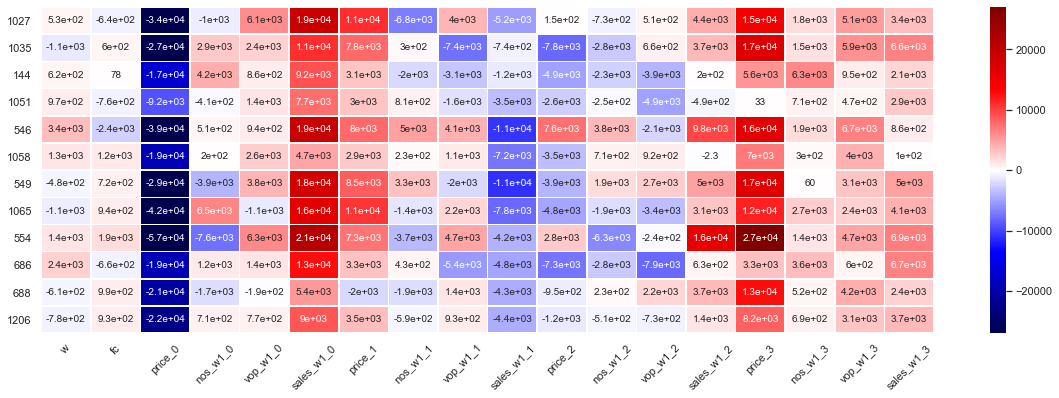

In [11]:
initial_epoch=51
lasso_coefs=pd.DataFrame()
seed=1234
for i,r in sku.iterrows():    
    data=eval('sku_'+i)
    for epoch in range(initial_epoch,data.shape[0]):
        X = data.drop(columns=['t']).iloc[:epoch]
        Xtr = StandardScaler().fit_transform(X)
        ytr = data["t"].iloc[:epoch]
        lasso_model = Lasso(alpha=1,max_iter=300,random_state=seed)
        lasso_model.fit(Xtr,ytr)
        if epoch==initial_epoch:
            lasso_coefs[i]=pd.Series(lasso_model.coef_,index=X.columns)
        else:
            lasso_coefs[i]=lasso_coefs[i]+pd.Series(lasso_model.coef_,index=X.columns)
    lasso_coefs[i]=lasso_coefs[i]/(data.shape[0]-initial_epoch)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(lasso_coefs.T,annot_kws={"size": 10},
            annot=True, linewidths=.5, ax=ax, cmap="seismic",vmax=lasso_coefs.max().max(),vmin=-lasso_coefs.max().max())
plt.yticks(rotation=0);
plt.xticks(rotation=45);
#     lr_coefficients = pd.DataFrame({'Variable':X.columns, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
#     plt.figure()
#     sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
#     plt.xticks(rotation=90);

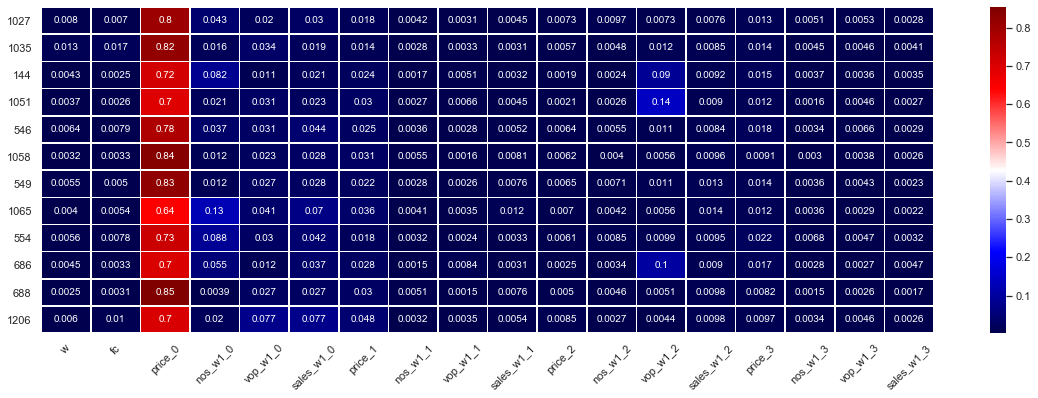

In [12]:
rt_imp=pd.DataFrame()
for i,r in sku.iterrows():    
    data=eval('sku_'+i)
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data.drop(columns=['t']).iloc[:epoch]
        ytr = data["t"].iloc[:epoch]
        forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
        forest.fit(Xtr, ytr)
        if epoch==initial_epoch:
            rt_imp[i]=pd.Series(forest.feature_importances_,index=X.columns)
        else:
            rt_imp[i]=rt_imp[i]+pd.Series(forest.feature_importances_,index=X.columns)
    rt_imp[i]=rt_imp[i]/(data.shape[0]-initial_epoch)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(rt_imp.T,annot_kws={"size": 10},
            annot=True, linewidths=.5, ax=ax, cmap="seismic")
plt.yticks(rotation=0);
plt.xticks(rotation=45);

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

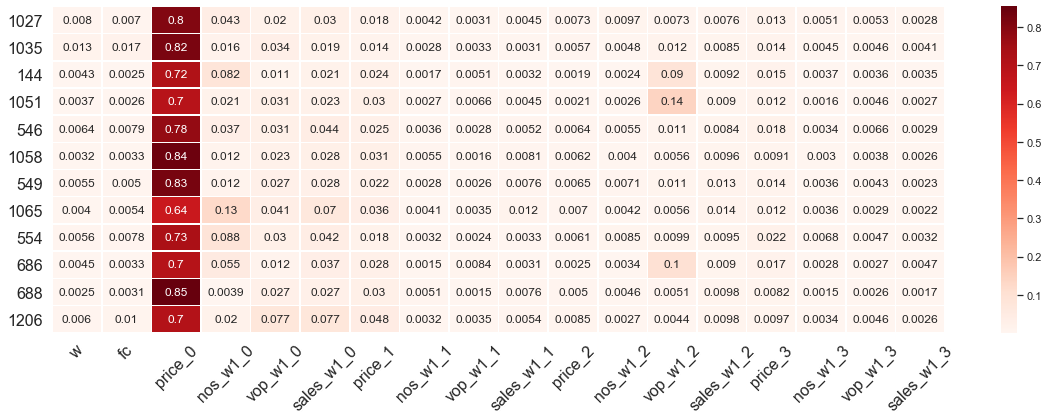

In [23]:
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(rt_imp.T,annot_kws={"size": 12},
            annot=True, linewidths=.5, ax=ax, cmap="Reds")
plt.xlabel('',fontsize=18)
plt.ylabel('',fontsize=18,labelpad=40)
plt.yticks(fontsize=16,rotation=0)
plt.xticks(fontsize=16,rotation=45)

In [85]:
relevant_features = {k: [] for k in rt_imp.columns}
for sk in relevant_features:
    for index,fi in rt_imp[sk].iteritems():
        if fi>.05:
            relevant_features[sk].append(index)

In [86]:
relevant_features

{'1027': ['price_0'],
 '1035': ['price_0'],
 '144': ['price_0', 'nos_w1_0', 'vop_w1_2'],
 '1051': ['price_0', 'vop_w1_2'],
 '546': ['price_0'],
 '1058': ['price_0'],
 '549': ['price_0'],
 '1065': ['price_0', 'nos_w1_0', 'sales_w1_0'],
 '554': ['price_0', 'nos_w1_0'],
 '686': ['price_0', 'nos_w1_0', 'vop_w1_2'],
 '688': ['price_0'],
 '1206': ['price_0', 'vop_w1_0', 'sales_w1_0']}